# TBCK
TBCK is a conserved protein kinase that associates with the mitotic apparatus and regulates cell size, cell proliferation, and MTOR (601231) signaling.
[Infantile hypotonia with psychomotor retardation and characteristic facies-3 (IHPRF3) ](https://omim.org/entry/616900) is caused by homozygous or compound heterozygous mutation in the TBCK gene.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.9.1.dev0


### TBCK
We use the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for TBCK.

In [2]:
gene_symbol = 'TBCK'
mane_tx_id = 'NM_001163435.3'
mane_protein_id = 'NP_001156907.2' # TBC domain-containing protein kinase-like protein isoform a [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()

with phenopacket_registry.open_phenopacket_store("0.1.21") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')


from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 41 phenopackets
Individuals Processed: 100%|██████████| 41/41 [01:03<00:00,  1.54s/individuals]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
35,Hypotonia
34,Motor delay
32,Global developmental delay
26,Seizure
20,Hyporeflexia
18,Absent speech
17,Coarse facial features
14,Macroglossia
14,"Intellectual disability, profound"
14,Narrow forehead


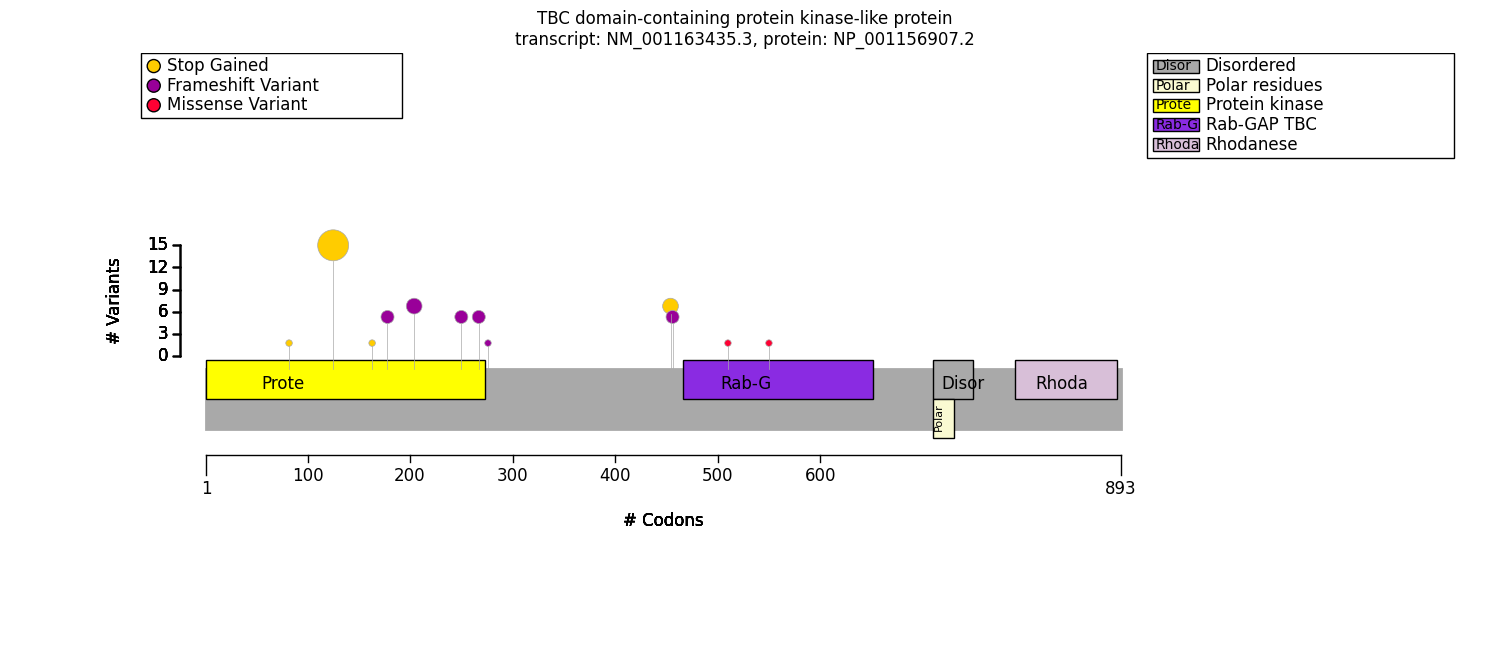

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


tbck_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
tbck_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
viewer = ProteinVariantViewer(protein_meta, mane_tx_id)
viewer.process(cohort)

Count,Name,Type,Coordinates,Variants
26,Protein kinase,Domain,2 - 273,p.Arg83Ter; p.Gln205ProfsTer8; p.Gln164Ter; p.Lys252Ter; p.Arg126Ter; p.Met268ArgfsTer26; p.Leu179ArgfsTer11
2,Rab-GAP TBC,Domain,467 - 651,p.Leu551Pro; p.Arg511His
0,Disordered,Region,711 - 749,
0,Polar residues,Compositional bias,711 - 730,
0,Rhodanese,Domain,791 - 889,


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_predicates = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_predicate = biallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    partitions=((0,1), (2,)),
    a_label="missense", 
    b_label="other"
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_predicate,
    pheno_clfs=pheno_predicates,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,37
HMF02,Skipping term because no genotype has more than one observed HPO count,1
HMF03,Skipping term because of a child term with the same individual counts,6
HMF05,Skipping term because one genotype had zero observations,2
HMF08,Skipping general term,72
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,192


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense/missense OR missense/other  \
                                                                                 Count   
Seizure [HP:0001250]                                                               0/2   
Scoliosis [HP:0002650]                                                             1/1   
Absent speech [HP:0001344]                                                         0/1   
Hyporeflexia [HP:0001265]                                                          1/2   
Deeply set eye [HP:0000490]                                                        1/2   
Macroglossia [HP:0000158]                                                          0/2   
Abnormal axial skeleton morphology [HP:0009121]                                    2/2   
Abnormal speech pattern [HP:0002167]                                               1/1   
Abnormal communication [HP:0034434]                                                1/1   
Delayed speech and language development [HP:000...                                 1/1   
Neurodevelopmental delay [HP:0012758]                                              2/2   
Neurodevelopmental abnormality [HP:0012759]                                        2/2   
Motor delay [HP:0001270]                                                           1/1   
Global developmental delay [HP:0001263]                                            2/2   
Reduced tendon reflexes [HP:0001315]                                               1/1   
Hypotonia [HP:0001252]                                                             2/2   
Abnormal oral cavity morphology [HP:0000163]                                       1/1   
Abnormality of the mouth [HP:0000153]                                              1/1   
Coarse facial features [HP:0000280]                                                1/2   
Abnormal facial shape [HP:0001999]                                                 1/1   
Abnormality of the forehead [HP:0000290]                                           1/1   
Global brain atrophy [HP:0002283]                                                  0/1   

Allele group                                               other/other  \
                                                   Percent       Count   
Seizure [HP:0001250]                                    0%       28/37   
Scoliosis [HP:0002650]                                100%        3/16   
Absent speech [HP:0001344]                              0%       18/23   
Hyporeflexia [HP:0001265]                              50%       19/23   
Deeply set eye [HP:0000490]                            50%        5/19   
Macroglossia [HP:0000158]                               0%       14/32   
Abnormal axial skeleton morphology [HP:0009121]       100%       17/17   
Abnormal speech pattern [HP:0002167]                  100%       24/24   
Abnormal communication [HP:0034434]                   100%       24/24   
Delayed speech and language development [HP:000...    100%       24/24   
Neurodevelopmental delay [HP:0012758]                 100%       39/39   
Neurodevelopmental abnormality [HP:0012759]           100%       39/39   
Motor delay [HP:0001270]                              100%       33/34   
Global developmental delay [HP:0001263]               100%       30/30   
Reduced tendon reflexes [HP:0001315]                  100%       27/27   
Hypotonia [HP:0001252]                                100%       39/39   
Abnormal oral cavity morphology [HP:0000163]          100%       26/26   
Abnormality of the mouth [HP:0000153]                 100%       26/26   
Coarse facial features [HP:0000280]                    50%       16/32   
Abnormal facial shape [HP:0001999]                    100%       16/16   
Abnormality of the forehead [HP:0000290]              100%       19/19   
Global brain atrophy [HP:0002283]                       0%        8/20   

Allele group                                                  

In [10]:
from gpsea.analysis.predicate import variant_key

r126ter = variant_key("4_106262103_106262103_G_A") #c.376C>T	p.Arg126Ter
r126ter_predicate = biallelic_classifier(a_predicate=r126ter, 
                          b_predicate=~r126ter,
                          partitions=((0,), (1,2)),
                          a_label="R126*", 
                          b_label="other")
r126ter_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=r126ter_predicate,
    pheno_clfs=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=r126ter_result)

Allele group                                       R126*/R126*          \
                                                         Count Percent   
Macroglossia [HP:0000158]                                11/12     92%   
Developmental regression [HP:0002376]                     9/12     75%   
Seizure [HP:0001250]                                     12/12    100%   
Coarse facial features [HP:0000280]                      10/12     83%   
Scoliosis [HP:0002650]                                     2/2    100%   
Global brain atrophy [HP:0002283]                          5/7     71%   
Hirsutism [HP:0001007]                                     1/2     50%   
Hyporeflexia [HP:0001265]                                  4/4    100%   
Macrocephaly [HP:0000256]                                  1/2     50%   
Abnormal axial skeleton morphology [HP:0009121]            2/2    100%   
Absent speech [HP:0001344]                                 2/2    100%   
Abnormal speech pattern [HP:0002167]                       2/2    100%   
Abnormal communication [HP:0034434]                        2/2    100%   
Delayed speech and language development [HP:000...         2/2    100%   
Neurodevelopmental delay [HP:0012758]                    12/12    100%   
Neurodevelopmental abnormality [HP:0012759]              12/12    100%   
Motor delay [HP:0001270]                                 10/10    100%   
Global developmental delay [HP:0001263]                    4/4    100%   
Reduced tendon reflexes [HP:0001315]                     12/12    100%   
Hypotonia [HP:0001252]                                   12/12    100%   
Morphological central nervous system abnormalit...         7/7    100%   
Abnormal brain morphology [HP:0012443]                     7/7    100%   
Abnormal oral cavity morphology [HP:0000163]             11/11    100%   
Abnormality of the mouth [HP:0000153]                    11/11    100%   
Abnormal facial shape [HP:0001999]                       10/10    100%   
Abnormality of the forehead [HP:0000290]                 10/10    100%   

Allele group                                       R126*/other OR other/other  \
                                                                        Count   
Macroglossia [HP:0000158]                                                3/22   
Developmental regression [HP:0002376]                                    2/22   
Seizure [HP:0001250]                                                    16/27   
Coarse facial features [HP:0000280]                                      7/22   
Scoliosis [HP:0002650]                                                   2/15   
Global brain atrophy [HP:0002283]                                        3/14   
Hirsutism [HP:0001007]                                                   3/20   
Hyporeflexia [HP:0001265]                                               16/21   
Macrocephaly [HP:0000256]                                                5/15   
Abnormal axial skeleton morphology [HP:0009121]                         17/17   
Absent speech [HP:0001344]                                              16/22   
Abnormal speech pattern [HP:0002167]                                    23/23   
Abnormal communication [HP:0034434]                                     23/23   
Delayed speech and language development [HP:000...                      23/23   
Neurodevelopmental delay [HP:0012758]                                   29/29   
Neurodevelopmental abnormality [HP:0012759]                             29/29   
Motor delay [HP:0001270]                                                24/25   
Global developmental delay [HP:0001263]                                 28/28   
Reduced tendon reflexes [HP:0001315]                                    16/16   
Hypotonia [HP:0001252]                                                  29/29   
Morphological central nervous system abnormalit...                      10/10   
Abnormal brain morphology [HP:0012443]                          

In [12]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_predicates,
)

summarize_hpo_analysis(hpo, mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Macroglossia [HP:0000158]                            1/12      8%  13/22   
Coarse facial features [HP:0000280]                  2/12     17%  15/22   
Global brain atrophy [HP:0002283]                     1/9     11%   7/12   
Hyporeflexia [HP:0001265]                           11/12     92%   9/13   
Tented upper lip vermilion [HP:0010804]              2/10     20%   5/11   
Motor delay [HP:0001270]                            13/14     93%  21/21   
Absent speech [HP:0001344]                          11/14     79%   7/10   
Macrocephaly [HP:0000256]                            4/10     40%    2/7   
Abnormal axial skeleton morphology [HP:0009121]     10/10    100%    9/9   
Abnormal speech pattern [HP:0002167]                14/14    100%  11/11   
Abnormal communication [HP:0034434]                 14/14    100%  11/11   
Delayed speech and language development [HP:000...  14/14    100%  11/11   
Neurodevelopmental delay [HP:0012758]               17/17    100%  24/24   
Neurodevelopmental abnormality [HP:0012759]         17/17    100%  24/24   
Global developmental delay [HP:0001263]             17/17    100%  15/15   
Reduced tendon reflexes [HP:0001315]                11/11    100%  17/17   
Seizure [HP:0001250]                                11/15     73%  17/24   
Hypotonia [HP:0001252]                              17/17    100%  24/24   
Morphological central nervous system abnormalit...    7/7    100%  10/10   
Abnormal brain morphology [HP:0012443]                7/7    100%  10/10   
Abnormal oral cavity morphology [HP:0000163]          8/8    100%  19/19   
Abnormality of the mouth [HP:0000153]                 8/8    100%  19/19   
Abnormal facial shape [HP:0001999]                    2/2    100%  15/15   
Abnormality of the forehead [HP:0000290]              6/6    100%  14/14   

Sex                                                                            \
                                                   Percent Corrected p values   
Macroglossia [HP:0000158]                              59%           0.125241   
Coarse facial features [HP:0000280]                    68%           0.125241   
Global brain atrophy [HP:0002283]                      58%           0.534985   
Hyporeflexia [HP:0001265]                              69%           1.000000   
Tented upper lip vermilion [HP:0010804]                45%           1.000000   
Motor delay [HP:0001270]                              100%           1.000000   
Absent speech [HP:0001344]                             70%           1.000000   
Macrocephaly [HP:0000256]                              29%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Abnormal speech pattern [HP:0002167]                  100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Delayed speech and language development [HP:000...    100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Global developmental delay [HP:0001263]               100%           1.000000   
Reduced tendon reflexes [HP:0001315]                  100%           1.000000   
Seizure [HP:0001250]                                   71%           1.000000   
Hypotonia [HP:0001252]                                100%           1.000000   
Morphological central nervous system abnormalit...    100%           1.000000   
Abnormal brain morphology [HP:0012443]                100%           1.000000   
Abnormal oral cavity morphology [HP:0000163]          100%           1.000000   
Abnormality of the mouth [HP:0000153]                 100%           1.000000   
Abnormal facial shape [HP:0001999]                    100%           1.000000  

# Summary

In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=r126ter_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),
)

caption = "Durham et al (2023) stated that several studies have touched on a genotype-phenotype correlation of TBCK syndrome; however, more data are required for statistically significant conclusions ).."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [14]:
summarizer.process_latex(report=report, protein_fig=tbck_fig)

Figure saved to ../../supplement/img/TBCK_protein_diagram-draft.pdf
Output to ../../supplement/tex/TBCK_summary_draft.tex
